# ¿Qué tan buenos somos para reconocer personas?

<img src="https://i.imgur.com/ECpBSfn.jpg" width="50%" />

<center>¿Jack Nicholson o Leonardo Dicaprio?</center>

<img src="http://1.bp.blogspot.com/_BQ05SdY_Qk0/SmoUY1TVaeI/AAAAAAAAAUE/NwiqQgpb_Dg/s400/Fabio+Posca+-+Bob+Pati%C3%B1o.jpg" width="50%" />

<div>

<img src="https://i.imgur.com/1IokFVT.png" width="50%" />

</div>

<center>¿Fisa o guerrero medieval?</center>

Como queda claro, a veces la cosa se puede complicar y no resulta tan sencillo :). 

Para poder hacer esto, tenemos un conjunto de datos de datos que consiste en algunas miles de imágenes clasificadas de ariel, fisa, gabi y mariano. En cada uno de estos casos tenemos la certeza (etiqueta) de quién es quién en cada uno. Este set de datos lo vamos a usar para entrenar el modelo y ver qué tan bien le está yendo a la hora de clasificar esas personas.

# Dependencias

Vamos a estar usando varias libs útiles, que se instalan con pip:

    pip install pillow scikit-learn pandas matplotlib tensorflow h5py sh jupyter --upgrade

# Generar imágenes a partir de videos (opcional)

Para este caso en particular, extrajimos imágenes de un grupo de videos usando el programa `ffmpeg`. En linux, puede instalarse con:

    sudo apt install ffmpeg 
    
Y luego se pueden generar imágenes a partir de un video, usándolo de esta forma:

    ffmpeg -i PATH_VIDEO -r FPS/1 PATH_IMAGENES/PREFIJO_%03d.jpg
    
Esto requiere especificar el path al video, los FPS que queremos sacar (cuántas imágenes por segundo de video), y el path y formato de los nombres de los archivos a generar. Por ejemplo, si tenemos un video "ariel.mp4", y queremos generar imágenes a 5 fps en un directorio "fotos_ariel", podríamos correrlo así:

    ffmpeg -i ariel.mp4 -r 5/1 fotos_ariel/foto_%03d.jpg


# Imports y configs

In [1]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

Datos
=====

Para que esto funcione, deben bajar y descomprimir los dos sets de imágenes desde [este link](https://drive.google.com/drive/folders/0B5cCDhynqkqDczZDd3JTSENFcDg?usp=sharing).

Cada set tiene 3 directorios de imágenes, uno por cada profe. Vamos a utilizar las imágenes con cortina de fondo como set de validación, y el resto como set de entrenamiento.

In [2]:
# lo vamos a estar usando seguido
PROFES = "ariel", "mariano", "fisa"
# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('./imagenes/train')
VALIDATION_DIR = Path('./imagenes/validation')
SIZE = (64, 64)

Lo primero que vamos a hacer es crear datasets de imágenes para Keras, usando sus propias herramientas (un ImageDataGenerator que es una especie de "lector" de imágenes de disco):

In [3]:
images_reader = ImageDataGenerator(
    rescale=1/255,
#    rotation_range=30,
#    width_shift_range=0.3,
#    height_shift_range=0.3,
#    brightness_range=(0.5, 1.5),
#    horizontal_flip=False,
#    vertical_flip=False,
)

READ_PARAMS = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=PROFES,  # para usar el mismo orden en todos lados
    target_size=SIZE,  # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
)

In [4]:
train = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS)
validation = images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS)

Found 2793 images belonging to 3 classes.
Found 869 images belonging to 3 classes.


Y con un poco de uso de Matplotlib, podemos mostrar ejemplos al azar de esas imágenes:

In [5]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(PROFES[np.argmax(labels[i])])
        plt.axis("off")

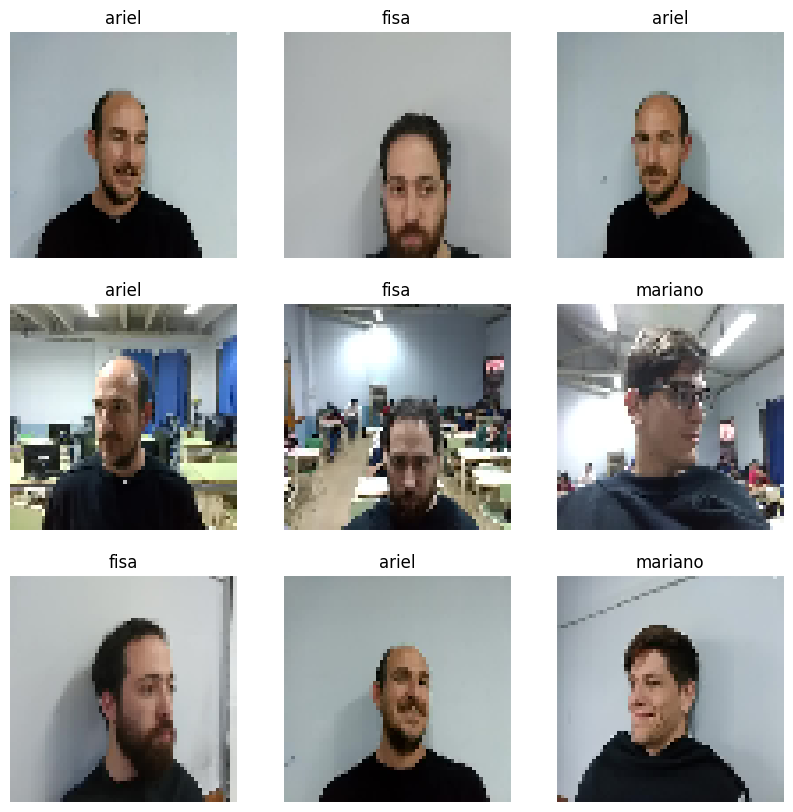

In [6]:
sample_images(train)

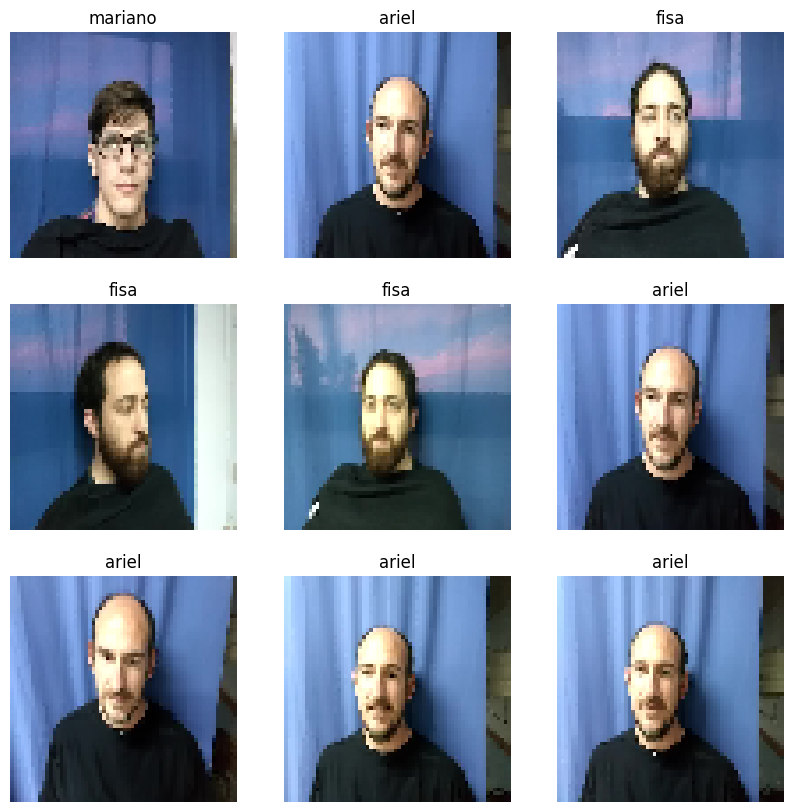

In [7]:
sample_images(validation)

Red neuronal
============

Y aquí es donde creamos y entrenamos el modelo. Vamos a usar redes convolucionales, porque se lleva naturalmente bien con el dataset que Keras nos sabe generar:

In [8]:
model = Sequential([
    # el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
    Convolution2D(input_shape=(SIZE[0], SIZE[1], 3), filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=4, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(10, activation='tanh'),
    Dropout(0.25),
    
    Dense(10, activation='tanh'),
    Dropout(0.25),

    Dense(len(PROFES), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 8)         392       
                                                                 
 dropout (Dropout)           (None, 61, 61, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 4)         516       
                                                                 
 dropout_1 (Dropout)         (None, 58, 58, 4)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 4)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                        

In [10]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [11]:
history = model.fit(
    train,
    epochs=10,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
88/88 [==============================] - 8s 75ms/step - loss: 0.8633 - accuracy: 0.6119 - val_loss: 1.1080 - val_accuracy: 0.3913
Epoch 2/10
88/88 [==============================] - 7s 78ms/step - loss: 0.3476 - accuracy: 0.9148 - val_loss: 0.9035 - val_accuracy: 0.5754
Epoch 3/10
88/88 [==============================] - 7s 76ms/step - loss: 0.1574 - accuracy: 0.9749 - val_loss: 1.2270 - val_accuracy: 0.5604
Epoch 4/10
88/88 [==============================] - 7s 82ms/step - loss: 0.0799 - accuracy: 0.9925 - val_loss: 1.1840 - val_accuracy: 0.6122
Epoch 5/10
88/88 [==============================] - 7s 79ms/step - loss: 0.0539 - accuracy: 0.9968 - val_loss: 1.3198 - val_accuracy: 0.6110
Epoch 6/10
88/88 [==============================] - 6s 68ms/step - loss: 0.0465 - accuracy: 0.9950 - val_loss: 1.3703 - val_accuracy: 0.6168
Epoch 7/10
88/88 [==============================] - 6s 68ms/step - loss: 0.0313 - accuracy: 0.9982 - val_loss: 1.3264 - val_accuracy: 0.6651
Epoch 8/10
88

Graficamos accuracy de ambos conjuntos durante todo el proceso

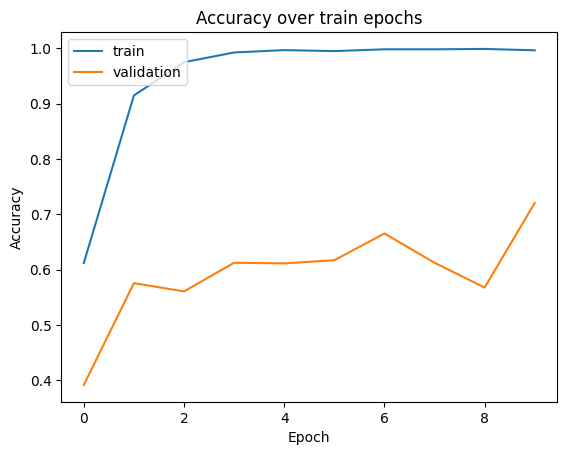

In [12]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [18]:
# nos quedamos con los mejores pesos
model.set_weights(model_weights_at_epochs[9])

Y analizamos un poco el error en ambos conjuntos, prediciendo y calculando métricas y matrices de confusión/

Found 2793 images belonging to 3 classes.
Found 869 images belonging to 3 classes.
######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 9ms/step
Accuracy: 1.0


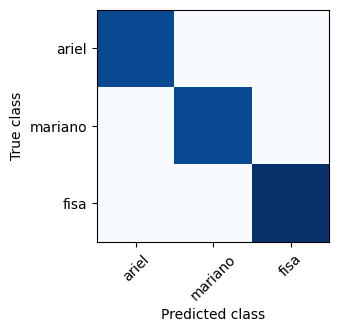

######################### validation #########################
Samples: 869
28/28 [==============================] - 0s 10ms/step
Accuracy: 0.7203682393555811


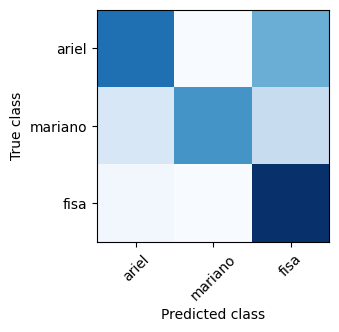

In [19]:
datasets = (
    ('train', images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS, batch_size=1000)),
    ('validation', images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS, batch_size=1000)),
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = dataset.next()
    print('Samples:', len(batch_images))
    
    # super importante: usamos argmax para convertir cosas de este formato:
    # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
    # a este formato (donde tenemos el índice de la clase que tiene número más alto):
    # [1, 0, 0, 2]
    predictions = np.argmax(model.predict(batch_images), axis=-1)
    labels = np.argmax(batch_labels, axis=-1)
    
    print('Accuracy:', accuracy_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1, 2], PROFES, rotation=45)
    plt.yticks([0, 1, 2], PROFES)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

# Y ahora con imágenes nuevas, podemos usar nuestro predictor!

In [20]:
from IPython.display import Image, display


def show_and_predict(image_path):
    image_array = img_to_array(load_img(image_path, target_size=SIZE))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", PROFES[np.argmax(predictions)])
    print("Prediction detail:", predictions)

1/1 [==============================] - 0s 19ms/step


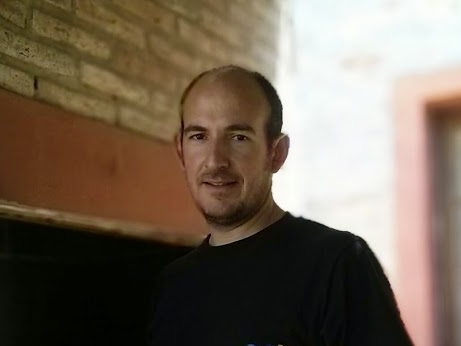

Prediction: ariel
Prediction detail: [[8.0436480e-01 1.9517253e-01 4.6261822e-04]]


In [21]:
show_and_predict("./ariel_asado.jpg")

1/1 [==============================] - 0s 19ms/step


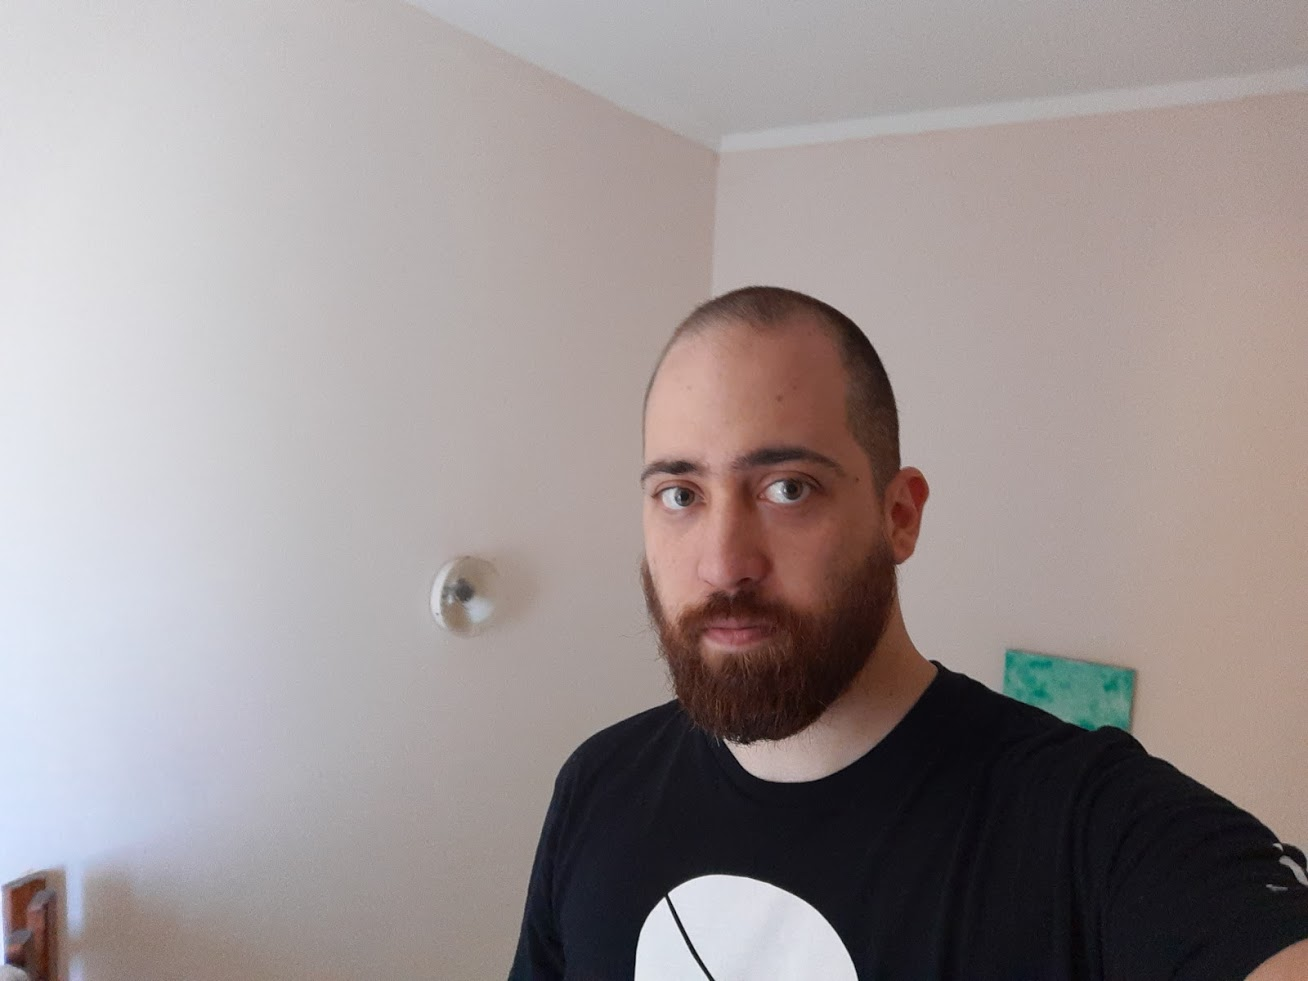

Prediction: fisa
Prediction detail: [[0.00158332 0.00205321 0.99636346]]


In [22]:
show_and_predict("./fisa_pelado.jpg")